# City spending on education

**Base URL for proper table layout:**

https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A7760

**URLs for each year:**

2024 = 45067NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A7760

2023 = 45063NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45063NED/table?dl=A7760

2022 = 45059NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45059NED/table?dl=A7760

2021 = 45054NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45054NED/table?dl=A7760

2020 = 45050NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45050NED/table?dl=A7760

2019 = 45046NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45046NED/table?dl=A7760

2018 = 45042NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45042NED/table?dl=A7760

2017 = 45038NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45038NED/table?dl=A7760

**=== everything below has different schema, not used! ===**

2016 = 45031NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45031NED/table?dl=A7760

2015 = 45006NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45006NED/table?dl=A7760

2014 = 45005NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45005NED/table?dl=A7760

2013 = 45004NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45004NED/table?dl=A7760

2012 = 45001NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45001NED/table?dl=A7760

2011 = 45008NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45008NED/table?dl=A7760

2010 = 45007NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45007NED/table?dl=A7760

In [8]:
!pip install matplotlib

     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     ------- ------------------------------- 30.7/165.5 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.2/8.0 MB 25.7 MB/s eta 0:00:01
   --------------- ------------------------ 3.0/8.0 MB 32.0 MB/s eta 0:00:01
   --------------------------- ------------ 5.4/8.0 MB 38.1 MB/s eta 0:00:01
   ------------------------------------- -- 7.5/8.0 MB 39.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 39.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/188.2 kB ? eta -:--:--
   --------------------------------------- 188.2/188.2 kB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------------------ --------- 1.7/2.2 MB 36.7 MB/s eta 0:00:01
   -------------

In [9]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

DATA_DIR = Path.cwd()  # is recursive, subdirectories are also searched for correct .csv files automatically

In [4]:
def get_csv(filename_snippet: str) -> Path:
    files = list(DATA_DIR.rglob(f'{filename_snippet}*.csv'))
    if files:
        return files[0]
    else:
        raise FileNotFoundError(f'No .csv file found containing "{filename_snippet}"')

In [5]:
def get_year_df(path: Path) -> pd.DataFrame:
    year = re.match('Gemeenten_(\d{4})_', path.stem).group(1)  # regex the year from the filename
    df = pd.read_csv(path, skiprows=4, skipfooter=1, sep=';', engine='python')
    
    # rename the columns, drop the last header row, add a Year column
    df.rename(columns={'Unnamed: 0': 'Gemeenten', 'Unnamed: 1': 'Verslagsoort', 'Categorie': 'Taakveld/balanspost'}, inplace=True)
    df.drop(0, inplace=True)
    df['Year'] = year
    
    # create a multi-index Year > City > Prediction/Actual > Category
    df.set_index(pd.MultiIndex.from_arrays([df['Year'], df['Gemeenten'], df['Verslagsoort'], df['Taakveld/balanspost']]), inplace=True)
    df.drop(['Year', 'Gemeenten', 'Verslagsoort', 'Taakveld/balanspost'], axis=1, inplace=True)
    
    # add a Total column
    df = df.apply(pd.to_numeric)
    df : pd.DataFrame  # the df.apply function returns type Any so this is to help the IDE
    df['Total'] = df.sum(axis=1, numeric_only=True)
    df.insert(0, 'Total', df.pop('Total'))
    
    # add a Total row for each index set (total for the 4.x expenses)
    totals = df.groupby(['Year', 'Gemeenten', 'Verslagsoort'])['Total'].sum().reset_index()
    totals['Taakveld/balanspost'] = '4.T TOTAL'
    totals.set_index(pd.MultiIndex.from_arrays([totals['Year'], totals['Gemeenten'], totals['Verslagsoort'], totals['Taakveld/balanspost']]), inplace=True)
    
    df = pd.concat([df, totals])
    df.drop(['Year', 'Gemeenten', 'Verslagsoort', 'Taakveld/balanspost'], axis=1, inplace=True)
    df.sort_index(inplace=True)
    return df


def load_years(search_dir: Path) -> pd.DataFrame:
    year_dfs = []
    
    for path in search_dir.rglob('Gemeenten_*.csv'):
        year_dfs.append(get_year_df(path))
    
    df = pd.concat(year_dfs)
    return df.sort_index()


load_years(DATA_DIR)

Total  \
Year Gemeenten          Verslagsoort Taakveld/balanspost                              
2017 Eindhoven          Begroting    4.1 Openbaar basisonderwijs                0.0   
                                     4.2 Onderwijshuisvesting               13377.0   
                                     4.3 Onderwijsbeleid en leerlingzaken   15780.0   
                                     4.T TOTAL                              29157.0   
                        Jaarrekening 4.1 Openbaar basisonderwijs                0.0   
...                                                                             ...   
2024 Utrecht (gemeente) Begroting    4.T TOTAL                             110794.0   
                        Jaarrekening 4.1 Openbaar basisonderwijs                0.0   
                                     4.2 Onderwijshuisvesting                   0.0   
                                     4.3 Onderwijsbeleid en leerlingzaken       0.0   
                                     4.T TOTAL                                  0.0   

                                                                           L1.1 Salarissen en sociale lasten  \
Year Gemeenten          Verslagsoort Taakveld/balanspost                                                       
2017 Eindhoven          Begroting    4.1 Openbaar basisonderwijs                                         0.0   
                                     4.2 Onderwijshuisvesting                                            0.0   
                                     4.3 Onderwijsbeleid en leerlingzaken                             2456.0   
                                     4.T TOTAL                                                           NaN   
                        Jaarrekening 4.1 Openbaar basisonderwijs                                         0.0   
...                                                                                                      ...   
2024 Utrecht (gemeente) Begroting    4.T TOTAL                                                           NaN   
                        Jaarrekening 4.1 Openbaar basisonderwijs                                         NaN   
                                     4.2 Onderwijshuisvesting                                            NaN   
                                     4.3 Onderwijsbeleid en leerlingzaken                                NaN   
                                     4.T TOTAL                                                           NaN   

                                                                           L2.1 Belastingen  \
Year Gemeenten          Verslagsoort Taakveld/balanspost                                      
2017 Eindhoven          Begroting    4.1 Openbaar basisonderwijs                        0.0   
                                     4.2 Onderwijshuisvesting                         905.0   
                                     4.3 Onderwijsbeleid en leerlingzaken              47.0   
                                     4.T TOTAL                                          NaN   
                        Jaarrekening 4.1 Openbaar basisonderwijs                        0.0   
...                                                                                     ...   
2024 Utrecht (gemeente) Begroting    4.T TOTAL                                          NaN   
                        Jaarrekening 4.1 Openbaar basisonderwijs                        NaN   
                                     4.2 Onderwijshuisvesting                           NaN   
                                     4.3 Onderwijsbeleid en leerlingzaken               NaN   
                                     4.T TOTAL                                          NaN   

                                                                           L3.1 Grond  \
Year Gemeenten          Verslagsoort Taakveld/balanspost                                
2017 Eindhoven          Begroting    4.1 Openbaar basisonderwijs           

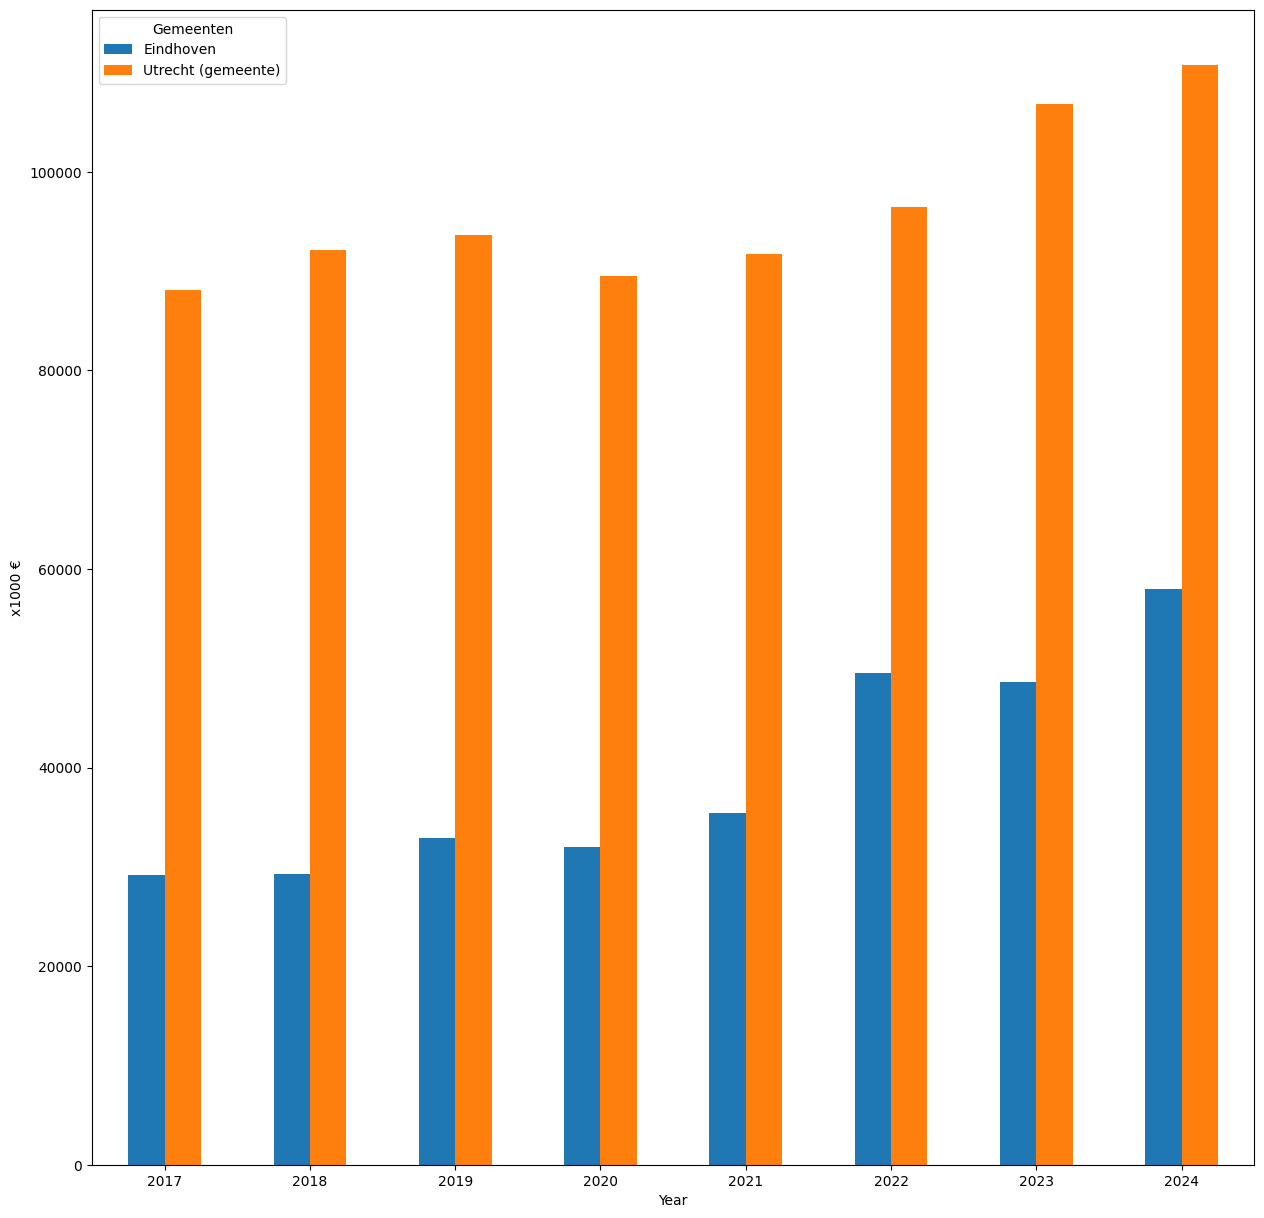

In [10]:
ONLY_SHOW_PRED_EXPENSES = True  # useful since we don't have actual expenses data for 2023 & 2024


def plot_expenses(kind='bar', subplots=False):
    df = load_years(DATA_DIR)
    
    df = df[df.index.isin(['4.T TOTAL'],  level=3)]
    df.set_index(df.index.droplevel(level=3), inplace=True)
    
    if ONLY_SHOW_PRED_EXPENSES:
        df = df[df.index.isin(['Begroting'],  level=2)]
        df.set_index(df.index.droplevel(level=2), inplace=True)
        unstack_levels = 1
    else:
        unstack_levels = (1, 2)
    
    df.unstack(level=unstack_levels).plot(y='Total', kind=kind, figsize=(15, 15), subplots=subplots, rot=0, ylabel='x1000 €')


plot_expenses()

# Enrollment rates

https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=A7762

In [11]:
def get_enrollment_df(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=3, skipfooter=1, sep=';', engine='python', na_values='.')
    
    # rename the columns, drop the last header row, add a Year column
    df.rename(columns={
        'Unnamed: 0': 'Year',
        'Unnamed: 1': 'Gemeenten',
        'Onderwijs|Naar woongemeente|Leerlingen/studenten|Voortgezet onderwijs': 'Secondary',
        'Onderwijs|Naar woongemeente|Leerlingen/studenten|Beroepsopleidende leerweg': 'MBO1',
        'Onderwijs|Naar woongemeente|Leerlingen/studenten|Beroepsbegeleidende leerweg': 'MBO2',
        'Onderwijs|Naar woongemeente|Leerlingen/studenten|Hoger beroepsonderwijs': 'HBO',
        'Onderwijs|Naar woongemeente|Leerlingen/studenten|Wetenschappelijk onderwijs': 'WO',
    }, inplace=True)
    df.drop(0, inplace=True)
    
    # create a multi-index Year > City > Prediction/Actual > Category
    df.set_index(pd.MultiIndex.from_arrays([df['Year'], df['Gemeenten']]), inplace=True)
    df.drop(['Year', 'Gemeenten'], axis=1, inplace=True)
    
    # add a Total column
    df = df.apply(pd.to_numeric)
    df : pd.DataFrame  # the df.apply function returns type Any so this is to help the IDE
    df['Total'] = df.sum(axis=1, numeric_only=True)
    df.insert(0, 'Total', df.pop('Total'))
    
    # sum both MBO variants, NOT included in total
    df['MBO Total'] = df['MBO1'] + df['MBO2']
    df.insert(4, 'MBO Total', df.pop('MBO Total'))

    df.sort_index(inplace=True)
    return df


get_enrollment_df(get_csv('Regionale_kerncijfers_'))

Total  Secondary    MBO1    MBO2  MBO Total  \
Year Gemeenten                                                           
1995 Eindhoven               0.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)      0.0        NaN     NaN     NaN        NaN   
1996 Eindhoven               0.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)      0.0        NaN     NaN     NaN        NaN   
1997 Eindhoven               0.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)      0.0        NaN     NaN     NaN        NaN   
1998 Eindhoven               0.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)      0.0        NaN     NaN     NaN        NaN   
1999 Eindhoven               0.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)      0.0        NaN     NaN     NaN        NaN   
2000 Eindhoven            9140.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)  20088.0        NaN     NaN     NaN        NaN   
2001 Eindhoven            9375.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)  20868.0        NaN     NaN     NaN        NaN   
2002 Eindhoven           10173.0        NaN     NaN     NaN        NaN   
     Utrecht (gemeente)  23310.0        NaN     NaN     NaN        NaN   
2003 Eindhoven           20291.0     9309.0     NaN     NaN        NaN   
     Utrecht (gemeente)  34488.0     9967.0     NaN     NaN        NaN   
2004 Eindhoven           21179.0     9474.0     NaN     NaN        NaN   
     Utrecht (gemeente)  37039.0    10053.0     NaN     NaN        NaN   
2005 Eindhoven           27098.0     9794.0  3731.0  1472.0     5203.0   
     Utrecht (gemeente)  45619.0    10736.0  4893.0  1330.0     6223.0   
2006 Eindhoven           27245.0     9937.0  3826.0  1486.0     5312.0   
     Utrecht (gemeente)  47289.0    10790.0  5221.0  1299.0     6520.0   
2007 Eindhoven           27204.0    10141.0  3754.0  1661.0     5415.0   
     Utrecht (gemeente)  48857.0    11191.0  5233.0  1516.0     6749.0   
2008 Eindhoven           27421.0     9908.0  3755.0  1841.0     5596.0   
     Utrecht (gemeente)  49336.0    11269.0  4992.0  1660.0     6652.0   
2009 Eindhoven           28554.0     9976.0  3853.0  2110.0     5963.0   
     Utrecht (gemeente)  51199.0    11598.0  5042.0  1782.0     6824.0   
2010 Eindhoven           28848.0     9966.0  3937.0  1865.0     5802.0   
     Utrecht (gemeente)  52246.0    12035.0  4961.0  2100.0     7061.0   
2011 Eindhoven           29069.0    10108.0  3837.0  1691.0     5528.0   
     Utrecht (gemeente)  52108.0    12627.0  4896.0  2062.0     6958.0   
2012 Eindhoven           29345.0    10146.0  3842.0  1721.0     5563.0   
     Utrecht (gemeente)  51566.0    13171.0  4904.0  1680.0     6584.0   
2013 Eindhoven           30202.0    10428.0  3902.0  1426.0     5328.0   
     Utrecht (gemeente)  53362.0    13945.0  4959.0  1358.0     6317.0   
2014 Eindhoven           30931.0    10603.0  3952.0  1077.0     5029.0   
     Utrecht (gemeente)  55931.0    14528.0  5039.0  1084.0     6123.0   
2015 Eindhoven           31105.0    10755.0  3868.0   963.0     4831.0   
     Utrecht (gemeente)  56524.0    15426.0  5195.0   995.0     6190.0   
2016 Eindhoven           31723.0    11012.0  3922.0  1035.0     4957.0   
     Utrecht (gemeente)  56032.0    16103.0  5423.0  1047.0     6470.0   
2017 Eindhoven           31917.0    10953.0  3917.0  1110.0     5027.0   
     Utrecht (gemeente)  55893.0    16777.0  5434.0  1092.0     6526.0   
2018 Eindhoven           32282.0    10899.0  3920.0  1168.0     5088.0   
     Utrecht (gemeente)  56305.0    17166.0  5669.0  1215.0     6884.0   
2019 Eindhoven           32601.0    10784.0  3942.0  1300.0     5242.0   
     Utrecht (gemeente)  56393.0    17681.0  5598.0  1320.0     6918.0   
2020 Eindhoven           33646.0    10728.0  4117.0  1286.0     5403.0   
     Utrecht (gemeente)  58467.0    18169.0  5738.0  1315.0     7053.0   
2021 Eindhoven           34173.

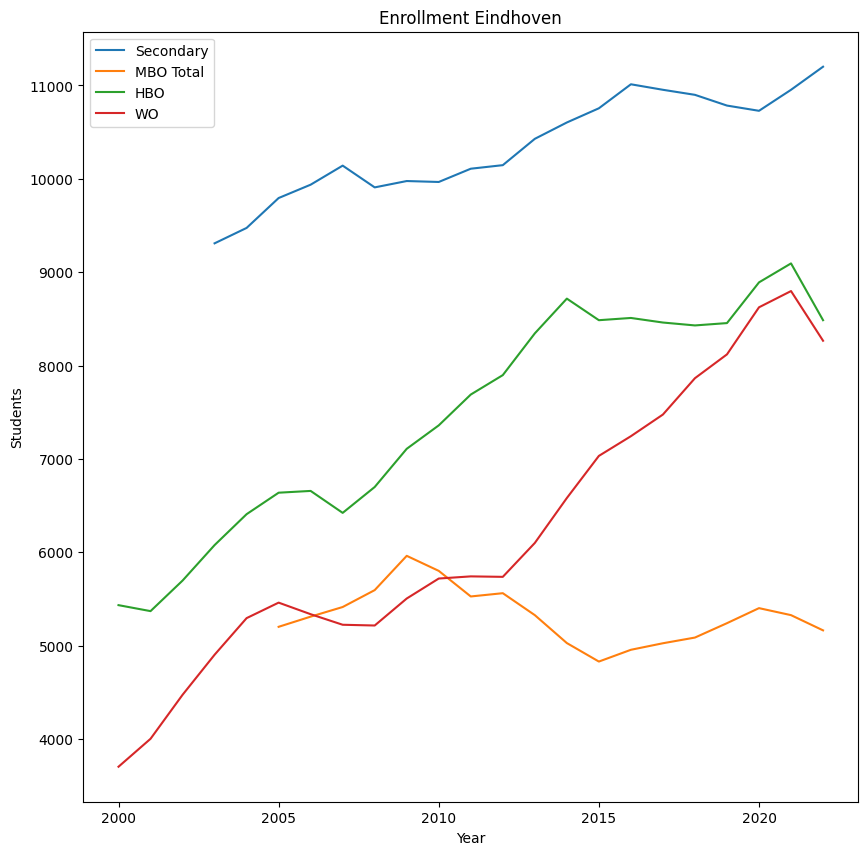

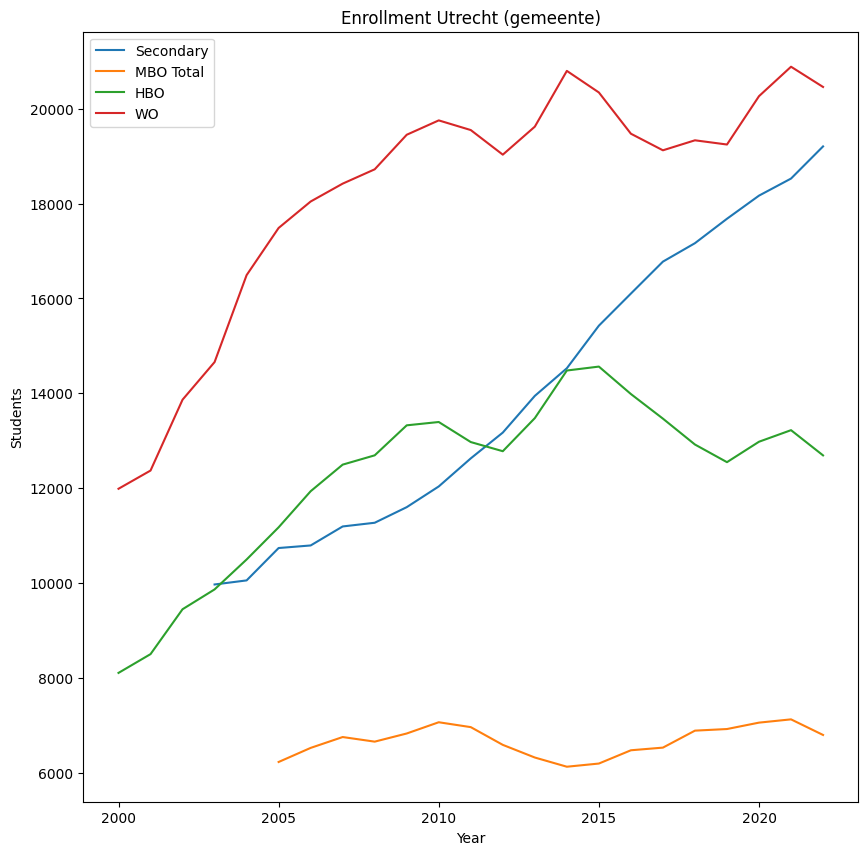

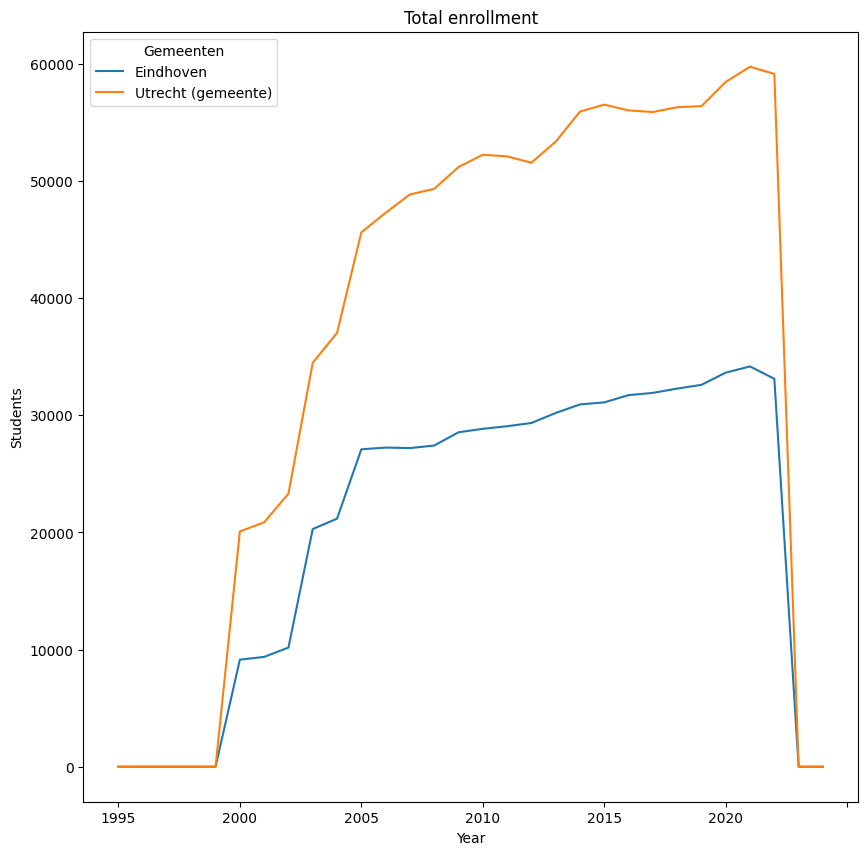

In [12]:
def plot_enrollment_city(kind='bar', subplots=False):
    df = get_enrollment_df(list(DATA_DIR.rglob('Regionale_kerncijfers_*.csv'))[0])
    
    for city in df.index.get_level_values('Gemeenten').unique():
        df_city = df.xs(city, level='Gemeenten')
        df_city.plot(y=['Secondary', 'MBO Total', 'HBO', 'WO'], kind=kind, title=f'Enrollment {city}', figsize=(10, 10), subplots=subplots, rot=0, ylabel='Students')


def plot_enrollment_total(kind='bar', subplots=False):
    df = get_enrollment_df(list(DATA_DIR.rglob('Regionale_kerncijfers_*.csv'))[0])
    
    df.unstack(level=1).plot(y='Total', kind=kind, title='Total enrollment', figsize=(10, 10), subplots=subplots, rot=0, ylabel='Students')


plot_enrollment_city(kind='line')
plot_enrollment_total(kind='line')

In [13]:
SPLIT_VMBO = False

def get_secondary_enrollment_df(path: Path) -> pd.DataFrame:

    def extract_secondary_type(text: str) -> str:
        if text == 'Praktijkonderwijs alle vj':
            return 'PRAKTIJK'
        elif text in ('Brugjaar 1-2', 'HAVO/VWO lj 3'):
            return 'HAVO/VWO'
        else:
            match = re.match('^(\w{4}) ([A-Z]{2})', text)  # check for VMBO with added category
            if match:
                if SPLIT_VMBO:
                    return f'{match.group(1)} {match.group(2)}'
                else:
                    return match.group(1)
            
            match = re.match('^(\w{3,4}) [a-z]{2}', text)  # check for HAVO or VWO, also captures "HAVO uitbesteed aan VAVO"
            if match:
                return match.group(1)
    
    df = pd.read_csv(path, sep=',', index_col='_id')
    
    df['PLAATSNAAM VESTIGING'] = df['PLAATSNAAM VESTIGING'].apply(str.capitalize)
    
    df.drop(['BEVOEGD GEZAG', 'NAAM BEVOEGD GEZAG', 'DENOMINATIE BG', 'BRIN NUMMER', 'VESTIGINGSNUMMER', 'BRINVESTIGINGSNUMMER', 'DENOMINATIE VESTIGING', 'INSTELLINGSNAAM VESTIGING', 'PROVINCIE VESTIGING', 'INDICATIE VO-VAVO', 'VMBO SECTOR', 'AFDELING'], axis=1, inplace=True)
    
    df['TYPE'] = df['ONDERWIJSTYPE VO EN LEER- OF VERBLIJFSJAAR'].apply(extract_secondary_type)
    
    df.set_index(pd.MultiIndex.from_arrays([df['SCHOOLJAAR'], df['PLAATSNAAM VESTIGING'], df['TYPE'], df['LEERJAAR']]), inplace=True)
    df.drop(['SCHOOLJAAR', 'PLAATSNAAM VESTIGING', 'TYPE', 'LEERJAAR', 'ONDERWIJSTYPE VO EN LEER- OF VERBLIJFSJAAR'], axis=1, inplace=True)
    
    df = df.groupby(level=(0, 1, 2)).sum()  # add level 3 to split by seniority year
    df.sort_index(inplace=True)
    
    return df


get_secondary_enrollment_df(get_csv('enrollment-secondary'))

AANTAL LEERLINGEN
SCHOOLJAAR PLAATSNAAM VESTIGING TYPE                       
2014       's-gravenhage        HAVO                   2916
                                HAVO/VWO              12880
                                PRAKTIJK               1084
                                VMBO                   5110
                                VWO                    3306
...                                                     ...
2018       Zwolle               HAVO                   1766
                                HAVO/VWO               6444
                                PRAKTIJK                276
                                VMBO                   2756
                                VWO                    1903

[6781 rows x 1 columns]

In [14]:
def get_poverty_df(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=4, skipfooter=1, sep=';', engine='python')
    
    # rename the columns, drop the last header row, add a Year column
    df.rename(columns={
        'Unnamed: 0': 'Year',
        'Unnamed: 1': 'Gemeenten',
        'Unnamed: 2': 'Inkomensgrens huishouden',
    }, inplace=True)
    df.drop(0, inplace=True)
    
    # create a multi-index Year > City > Category
    df.set_index(pd.MultiIndex.from_arrays([df['Year'], df['Gemeenten'], df['Inkomensgrens huishouden']]), inplace=True)
    df.drop(['Year', 'Gemeenten', 'Inkomensgrens huishouden'], axis=1, inplace=True)

    df.sort_index(inplace=True)
    return df


get_poverty_df(get_csv('Laag_en_langdurig_laag_inkomen_'))

Minderjarige kinderen  \
Year  Gemeenten          Inkomensgrens huishouden                                 
2011  Eindhoven          Inkomen tot 101% sociaal minimum                   3,0   
                         Inkomen tot 105% sociaal minimum                   3,9   
                         Inkomen tot 110% sociaal minimum                   4,5   
                         Inkomen tot 120% sociaal minimum                   5,5   
                         Inkomen tot 130% sociaal minimum                   6,3   
...                                                                         ...   
2022* Utrecht (gemeente) Inkomen tot 130% sociaal minimum                   7,7   
                         Inkomen tot 140% sociaal minimum                   8,7   
                         Inkomen tot 150% sociaal minimum                   9,6   
                         Inkomen tot lage-inkomensgrens                     4,2   
                         Totaal                                            68,3   

                                                          Minderjarige kinderen relatief  
Year  Gemeenten          Inkomensgrens huishouden                                         
2011  Eindhoven          Inkomen tot 101% sociaal minimum                            8,0  
                         Inkomen tot 105% sociaal minimum                           10,3  
                         Inkomen tot 110% sociaal minimum                           12,0  
                         Inkomen tot 120% sociaal minimum                           14,5  
                         Inkomen tot 130% sociaal minimum                           16,8  
...                                                                                  ...  
2022* Utrecht (gemeente) Inkomen tot 130% sociaal minimum                           11,3  
                         Inkomen tot 140% sociaal minimum                           12,7  
                         Inkomen tot 150% sociaal minimum                           14,0  
                         Inkomen tot lage-inkomensgrens                              6,2  
                         Totaal                                                    100,0  

[216 rows x 2 columns]

In [30]:
def process_education_data(file_path):
    # Load the CSV file into a dataframe
    df = pd.read_csv(file_path)
    
    def process_city_data(df, city_code, city_name):
        # Filter the dataframe to include only rows where GEMEENTENUMMER matches the city_code
        city_df = df[df['GEMEENTENUMMER'] == city_code].copy()
        
        # Add a new column 'Plaatsnaam' with the city_name for the matching rows
        city_df.loc[:, 'Plaatsnaam'] = city_name
        
        # Replace -1 with 0 in 'AANTAL_LEERLINGEN' column
        city_df.loc[:, 'AANTAL_LEERLINGEN'] = city_df['AANTAL_LEERLINGEN'].replace(-1, 0)
        
        # Group the filtered data by 'PEILJAAR' and 'Plaatsnaam', summing the 'AANTAL_LEERLINGEN' for each year
        grouped_city_df = city_df.groupby(['PEILJAAR', 'Plaatsnaam']).agg({'AANTAL_LEERLINGEN': 'sum'}).reset_index()
        
        return grouped_city_df

    # Process data for Utrecht and Eindhoven
    utrecht_data = process_city_data(df, 344, 'Utrecht')
    eindhoven_data = process_city_data(df, 772, 'Eindhoven')
    
    # Combine the Utrecht and Eindhoven grouped dataframes
    combined_df = pd.concat([utrecht_data, eindhoven_data]).reset_index(drop=True)
    
    # Group the combined data by 'PEILJAAR' and 'Plaatsnaam', summing the 'AANTAL_LEERLINGEN' for each year
    multi_index_combined_df = combined_df.set_index(['PEILJAAR', 'Plaatsnaam']).sort_index()

    # Rename the index levels
    multi_index_combined_df.index.rename(['Year', 'Gemeenten'], inplace=True)

    return multi_index_combined_df

def plot_students_over_time(multi_index_combined_df):
    plt.figure(figsize=(12, 6))
    
    for city in multi_index_combined_df.index.get_level_values('Plaatsnaam').unique():
        city_data = multi_index_combined_df.xs(city, level='Plaatsnaam')
        plt.plot(city_data.index, city_data['AANTAL_LEERLINGEN'], marker='o', label=city)
    
    plt.title('Number of Students Over Time per City')
    plt.xlabel('Year')
    plt.ylabel('Number of Students')
    plt.legend(title='City')
    plt.grid(True)
    plt.show()
    
file_path = get_csv('primary_education_2010_2023')
primary_education_df = process_education_data(file_path)
primary_education_df

AANTAL_LEERLINGEN
Year Gemeenten                   
2010 Eindhoven              18232
     Utrecht                27973
2011 Eindhoven              18287
     Utrecht                28661
2012 Eindhoven              18394
     Utrecht                29513
2013 Eindhoven              18468
     Utrecht                30212
2014 Eindhoven              18524
     Utrecht                30917
2015 Eindhoven              18576
     Utrecht                31261
2016 Eindhoven              18482
     Utrecht                31699
2017 Eindhoven              18301
     Utrecht                31865
2018 Eindhoven              18272
     Utrecht                32094
2019 Eindhoven              18306
     Utrecht                32077
2020 Eindhoven              18137
     Utrecht                31994
2021 Eindhoven              17881
     Utrecht                31528
2022 Eindhoven              18055
     Utrecht                31343
2023 Eindhoven              18125
     Utrecht                31155

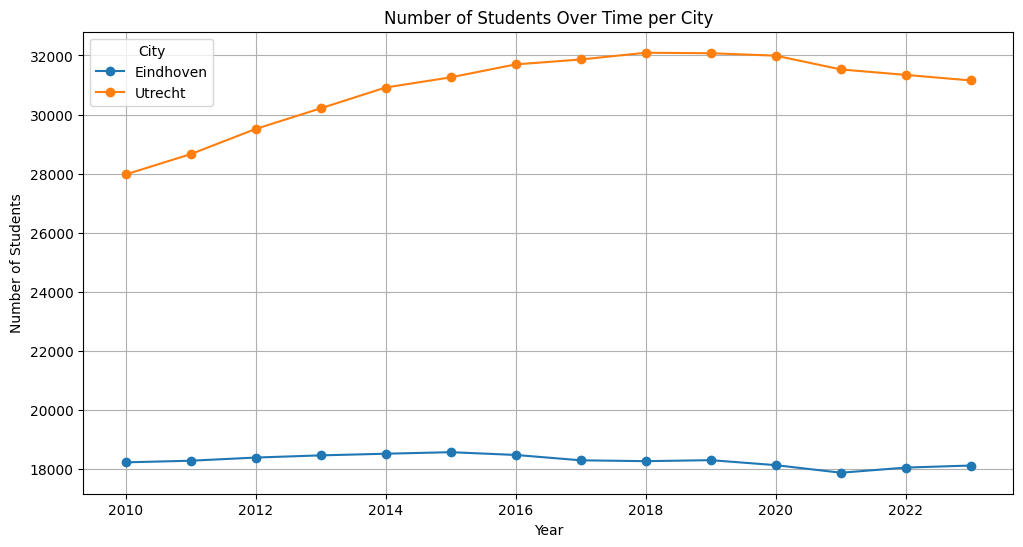

In [32]:
import matplotlib.pyplot as plt

def plot_students_over_time(multi_index_combined_df):
    plt.figure(figsize=(12, 6))
    
    for city in multi_index_combined_df.index.get_level_values('Gemeenten').unique():
        city_data = multi_index_combined_df.xs(city, level='Gemeenten')
        plt.plot(city_data.index, city_data['AANTAL_LEERLINGEN'], marker='o', label=city)
    
    plt.title('Number of Students Over Time per City')
    plt.xlabel('Year')
    plt.ylabel('Number of Students')
    plt.legend(title='City')
    plt.grid(True)
    plt.show()

# General plot
plot_students_over_time(primary_education_df)